## Cape Cod - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Cape Cod

#### Install and import the required libraries

In [1]:
import sys
#! python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

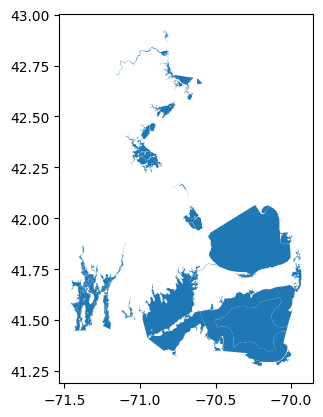

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url)  # Already 4326 standard
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(10580, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(10580, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits'}

<Axes: >

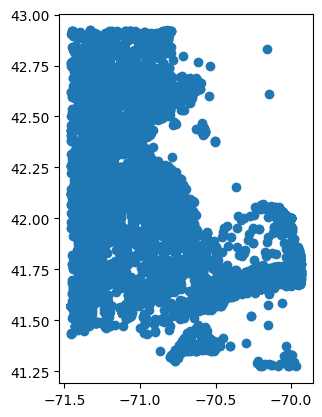

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

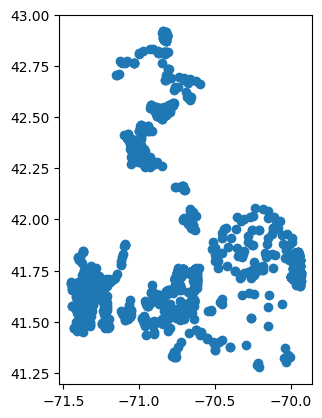

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1519

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path,'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (8,10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,130809111433.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX30_21_7/22/2013_SFW_0.01,2013-07-22,11:01:00,EDT,11NPSWRD_WQX-CACO_HX30_21,STORET-986369728,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,2013-07-30,14:20:00,EDT,MASSDEP-W2173,STORET-762955917,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,2013-06-30,12:00:00,EDT,IRWA-HB,STORET-853064665,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,2013-12-17,07:40:00,EST,CRWA-609S,STORET-872379847,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416607,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,EST,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
416608,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
416609,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
416610,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,EST,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

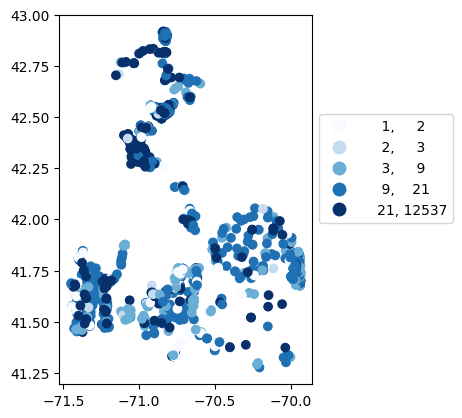

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)


-Usable results-
count    4859.000000
mean      -12.392416
std       405.605559
min     -9999.000000
25%         1.600000
50%         3.500000
75%         6.000000
max        17.000000
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2421.240935089463): 16


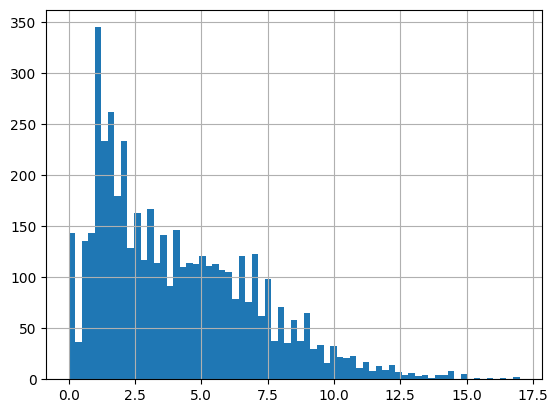

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
17,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
137,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
311,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
577,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
597,11113300-GRTKINSD,4.75,m,NaN,m,4.75 meter
...,...,...,...,...,...,...
415922,11NPSWRD_WQX-CACO_DUCK_W,16.5,m,NaN,m,16.5 meter
415923,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
415924,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
415925,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
10492,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
29771,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
32659,EPA_OCMA_R1-SS-3,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
34650,EPA_OCMA_R1-R1-23,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
36903,EPA_OCMA_R1-R1-25,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...,...
328138,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
328218,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
328574,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
329325,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
10492,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
29737,NARS_WQX-NCCA10-1070,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
29771,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
29918,NARS_WQX-NCCA10-1029,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
31135,NARS_WQX-NCCA10-1001,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...,...
328138,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
328218,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
328574,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
329325,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
689,WWMD_VA-SH1,2,1.500000
690,WWMD_VA-SH2,2,1.800000
691,WWMD_VA-SR6A,1,0.500000
692,WWMD_VA-WF2,1,0.600000


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

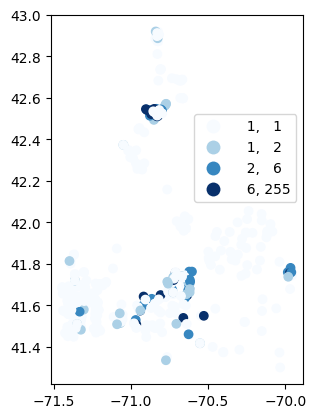

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

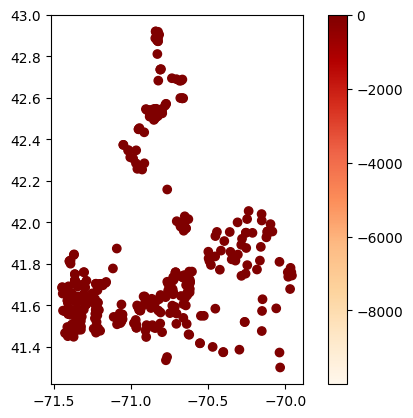

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    119742.000000
mean         16.041278
std           7.327751
min          -6.000000
25%          11.000000
50%          16.730000
75%          21.683374
max         910.000000
dtype: float64
Unusable results: 213
Usable results with inferred units: 217
Results outside threshold (0.0 to 60.007781720935796): 116


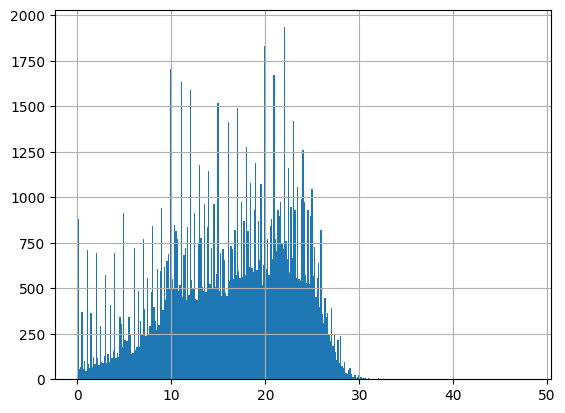

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
0,CRWA-ROB,23.01,deg C,NaN,23.01 degree_Celsius,degC
8,CRWA-635S,5.5,deg C,NaN,5.5 degree_Celsius,degC
15,CRWA-4LONG,28.2,deg C,NaN,28.2 degree_Celsius,degC
22,BRC-C-02-03-040,15,deg C,NaN,15.0 degree_Celsius,degC
26,11113300-BCHHSPHAMLF,15,deg C,NaN,15.0 degree_Celsius,degC
...,...,...,...,...,...,...
416594,USGS-413831070304703,11.3,deg C,NaN,11.3 degree_Celsius,degC
416596,USGS-01100627,7.0,deg C,NaN,7.0 degree_Celsius,degC
416600,USGS-01096548,2.9,deg C,NaN,2.9 degree_Celsius,degC
416604,USGS-01098530,1.5,deg C,NaN,1.5 degree_Celsius,degC


In [34]:
# Examine deg F
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'] == 'deg F']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
16228,NALMS-F865245,81,deg F,NaN,27.222222222222285 degree_Celsius,degF
22987,11113300-HOODERD,59.2,deg F,NaN,15.111111111111143 degree_Celsius,degF
23336,11113300-HOODERD,59.1,deg F,NaN,15.0555555555556 degree_Celsius,degF
23626,11113300-HOODERD,59.9,deg F,NaN,15.500000000000057 degree_Celsius,degF
24108,11113300-HOODERD,56,deg F,NaN,13.333333333333371 degree_Celsius,degF
...,...,...,...,...,...,...
412393,11NPSWRD_WQX-SAIR_MEQ76_NC6,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF
412399,11NPSWRD_WQX-SAMA_MEQ76_NC18,71.0,deg F,NaN,21.666666666666686 degree_Celsius,degF
412402,11NPSWRD_WQX-SAMA_MEQ76_NC13,72.0,deg F,NaN,22.222222222222285 degree_Celsius,degF
412417,11NPSWRD_WQX-SAIR_MEQ76_NC3,70.0,deg F,NaN,21.111111111111143 degree_Celsius,degF


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
100462,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
100463,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
100464,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
100465,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
100466,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
101804,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
101805,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
101807,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
123718,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
269,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
2958,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
3439,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
4263,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
4561,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
247574,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
262934,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
264182,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
268663,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
5928,WWMD_VA-WWE1149PI,1,18.800000
5929,WWMD_VA-WWE1150PI,1,21.300000
5930,WWMD_VA-WWE1151PI,2,20.700000
5931,WWMD_VA-WWE1152PI,1,20.000000


<Axes: >

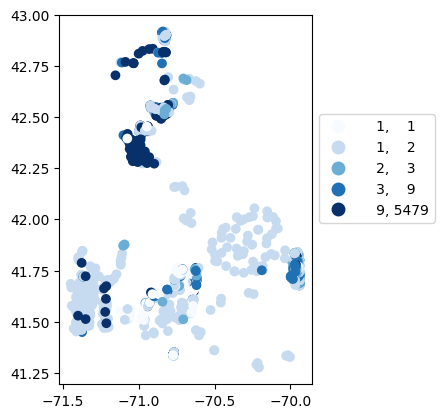

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

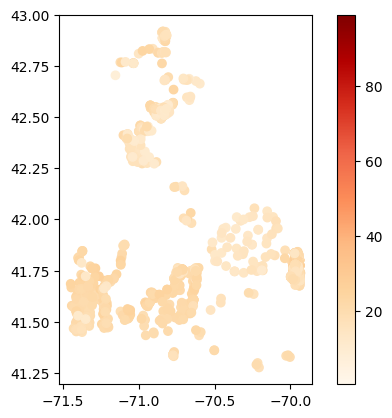

In [40]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
3,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
6,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
7,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
9,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
11,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/L,NaN,10.91 milligram / liter
...,...,...,...,...,...
413047,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
413050,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
413051,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/L,NaN,8.5 milligram / liter
413057,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
3,IRWA-HB,4.6,mg/L,NaN,4.6 milligram / liter
6,MYRWA-MEB001,9.4,mg/L,NaN,9.4 milligram / liter
7,NARS_WQX-MARO-1020,10.3,mg/L,NaN,10.3 milligram / liter
9,MASSDEP-W2412,8.7,mg/L,NaN,8.7 milligram / liter
11,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/L,NaN,10.91 milligram / liter
...,...,...,...,...,...
413047,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/L,NaN,6.1 milligram / liter
413050,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/L,NaN,14.2 milligram / liter
413051,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/L,NaN,8.5 milligram / liter
413057,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/L,NaN,9.1 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
2323,WWMD_VA-SR5,1,10.810000
2324,WWMD_VA-WF2,2,6.800000
2325,WWMD_VA-WI1,1,9.510000
2326,WWMD_VA-WR2X,2,6.000000


<Axes: >

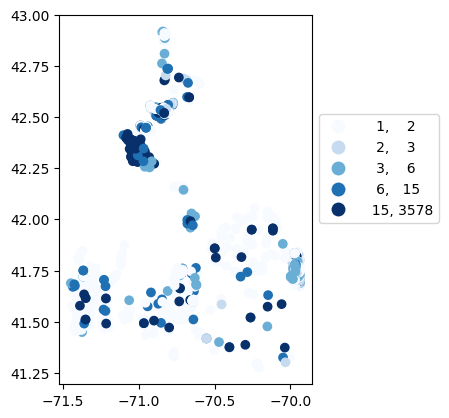

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

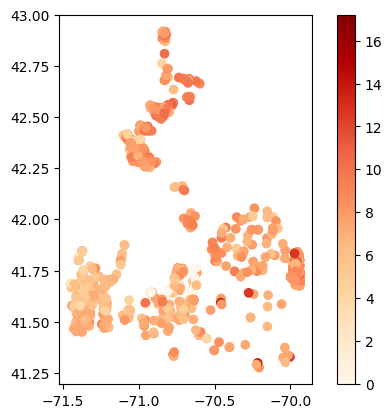

In [46]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

-Usable results-
count    94614.000000
mean         6.509265
std          2.641679
min         -3.124705
25%          5.700000
50%          6.620000
75%          7.320000
max        715.000000
dtype: float64
Unusable results: 17
Usable results with inferred units: 215
Results outside threshold (0.0 to 22.35933967770454): 12


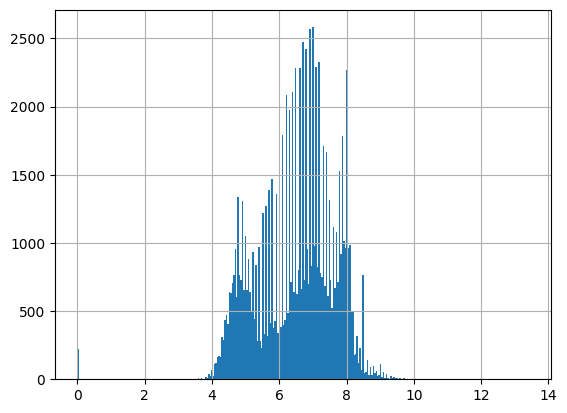

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
28,7.78,None,NaN,7.78 dimensionless
52,7.9,None,NaN,7.9 dimensionless
58,7.69,None,NaN,7.69 dimensionless
59,6.16,None,NaN,6.16 dimensionless
61,7.4,None,NaN,7.4 dimensionless
...,...,...,...,...
416595,5.8,std units,NaN,5.8 dimensionless
416597,7.3,std units,NaN,7.3 dimensionless
416601,7.4,std units,NaN,7.4 dimensionless
416605,7.5,std units,NaN,7.5 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/basis.py:154: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn(f"Mismatched {flag}", UserWarning)


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'deg C' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    30755.000000
mean        19.334149
std         27.164539
min          0.000000
25%          0.535000
50%         29.000000
75%         31.100000
max       4003.482834
dtype: float64
Unusable results: 217
Usable results with inferred units: 1
Results outside threshold (0.0 to 182.3213833602183): 2


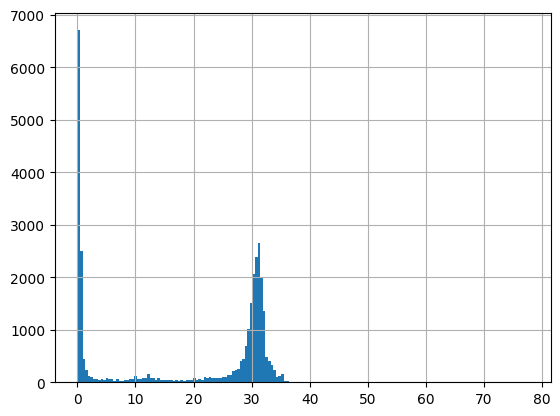

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
21,33.3,ppth,NaN,33.3 Practical_Salinity_Units
49,32.7,ppth,NaN,32.7 Practical_Salinity_Units
88,30.48,ppt,NaN,30.48 Practical_Salinity_Units
96,0.21,ppth,NaN,0.21 Practical_Salinity_Units
98,12.3,ppth,NaN,12.3 Practical_Salinity_Units
...,...,...,...,...
415403,9.9,PSU,NaN,9.9 Practical_Salinity_Units
416008,4.6,PSU,NaN,4.6 Practical_Salinity_Units
416108,21.0,PSU,NaN,21.0 Practical_Salinity_Units
416121,18.7,PSU,NaN,18.7 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


-Usable results-
count    2409.000000
mean        6.472302
std       106.930304
min         0.000800
25%         0.074000
50%         0.242000
75%         1.000000
max      2800.000000
dtype: float64
Unusable results: 243
Usable results with inferred units: 0
Results outside threshold (0.0 to 648.0541246058881): 6


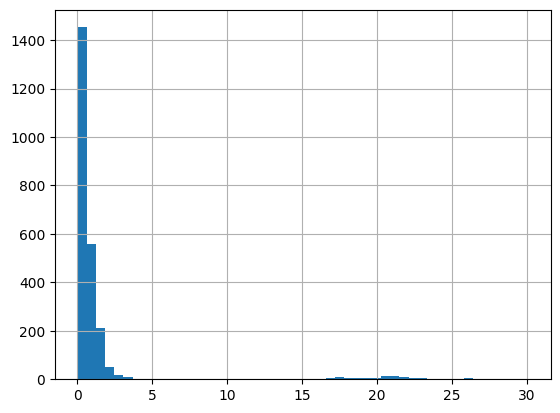

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
648,0.926976,mg/L,NaN,0.926976 milligram / liter
751,1.571196,mg/L,NaN,1.571196 milligram / liter
757,0.816144,mg/L,NaN,0.816144 milligram / liter
1018,0.848832,mg/L,NaN,0.848832 milligram / liter
1063,0.770448,mg/L,NaN,0.770448 milligram / liter
...,...,...,...,...
416428,0.119,mg/l,NaN,0.119 milligram / liter
416486,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
416529,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
416535,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Conductivity

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count     2599.000000
mean      1093.016402
std       4249.270869
min          0.000000
25%        280.500000
50%        402.000000
75%        553.000000
max      48600.000000
dtype: float64
Unusable results: 80
Usable results with inferred units: 0
Results outside threshold (0.0 to 26588.641616518235): 29


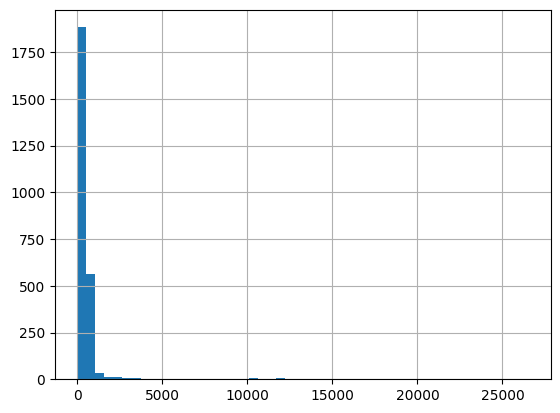

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True, errors='ignore')

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
18,349,uS/cm,NaN,349.0 microsiemens / centimeter
23,8,count,NaN,NaN
36,443,uS/cm,NaN,443.0 microsiemens / centimeter
43,67.11703531,uS/cm,NaN,67.11703531 microsiemens / centimeter
67,590,uS/cm,NaN,590.0 microsiemens / centimeter
...,...,...,...,...
310223,0.431,mS/cm,NaN,431.0 microsiemens / centimeter
310246,0.321,mS/cm,NaN,321.0 microsiemens / centimeter
310249,0.364,mS/cm,NaN,364.0 microsiemens / centimeter
310265,0.246,mS/cm,NaN,246.0 microsiemens / centimeter


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


-Usable results-
count    4156.000000
mean        0.583832
std         3.286460
min        -0.002400
25%         0.001900
50%         0.005200
75%         0.019000
max        92.900000
dtype: float64
Unusable results: 202
Usable results with inferred units: 9
Results outside threshold (0.0 to 20.302593411738652): 29


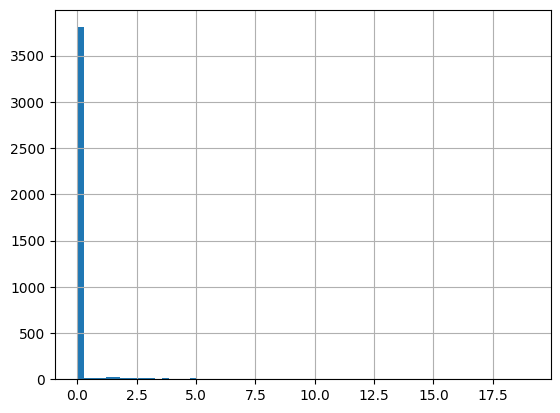

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
2,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
181,5.50,ug/L,NaN,0.0055 milligram / liter
342,9.48,ug/L,NaN,0.00948 milligram / liter
584,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
778,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
416312,0.5,ug/l,NaN,0.0005 milligram / liter
416319,2.5,ug/l,NaN,0.0025 milligram / liter
416332,0.7,ug/l,NaN,0.0007 milligram / liter
416365,1.1,ug/l,NaN,0.0011 milligram / liter


##### Organic Carbon

-Usable results-
count      6126.000000
mean       5300.199057
std       35634.927260
min      -90000.000000
25%           1.720000
50%           4.900000
75%           8.900000
max      530000.000000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 219109.7626196926): 40


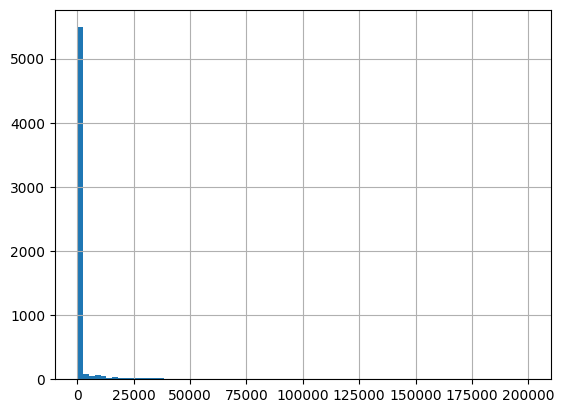

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
835,7.05,mg/L,NaN,7.05 milligram / liter
945,7.57,mg/L,NaN,7.57 milligram / liter
972,3.5,mg/L,NaN,3.5 milligram / liter
2545,3.8,mg/L,NaN,3.8 milligram / liter
3288,3.7,mg/L,NaN,3.7 milligram / liter
...,...,...,...,...
416416,7.01,mg/l,NaN,7.01 milligram / liter
416485,5.96,mg/l,NaN,5.96 milligram / liter
416528,4.1,mg/l,NaN,4.1 milligram / liter
416534,7.79,mg/l,NaN,7.79 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/harmonize.py:149: UserWarning: Bad Turbidity unit: count
  warn(f"Bad Turbidity unit: {unit}")


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    25833.000000
mean        20.034423
std         82.668605
min       -999.000000
25%          1.550000
50%          3.200000
75%          7.100000
max       4100.000000
dtype: float64
Unusable results: 547
Usable results with inferred units: 275
Results outside threshold (0.0 to 516.0460525509235): 168


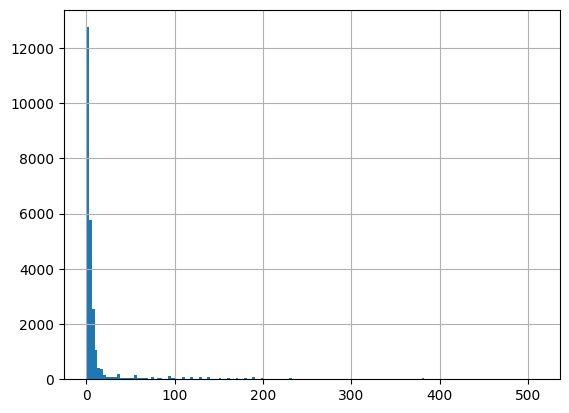

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
1,4.2,NTU,NaN,4.2 Nephelometric_Turbidity_Units
5,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
10,7.9,NTU,NaN,7.9 Nephelometric_Turbidity_Units
20,1.5,NTU,NaN,1.5 Nephelometric_Turbidity_Units
25,2.1,NTU,NaN,2.1 Nephelometric_Turbidity_Units
...,...,...,...,...
416589,1.6,NTRU,NaN,1.6 Nephelometric_Turbidity_Units
416599,5.8,NTRU,NaN,5.8 Nephelometric_Turbidity_Units
416603,2.1,NTRU,NaN,2.1 Nephelometric_Turbidity_Units
416607,2.9,NTRU,NaN,2.9 Nephelometric_Turbidity_Units


##### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False, errors='ignore')

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'g / H2O' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
374162,0.012,g,NaN,NaN
374163,0.0037,g,NaN,NaN
374164,0.0048,g,NaN,NaN
374165,0.001,g,NaN,NaN
374166,0.0088,g,NaN,NaN
...,...,...,...,...
415678,0.0051,g,NaN,NaN
415752,0.0025,g,NaN,NaN
415824,0.002,g,NaN,NaN
415863,0.0023,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
27,0.024,mg/L,NaN,NaN
30,0.05,mg/L,NaN,NaN
38,0.027,mg/L,NaN,NaN
46,0.059712,mg/L,NaN,NaN
93,0.049,mg/L,NaN,NaN
...,...,...,...,...
415885,0.006,mg/l as P,NaN,0.006 milligram / liter
415897,0.016,mg/l as P,NaN,NaN
415898,0.008,mg/l as P,NaN,0.008 milligram / liter
415905,0.047,mg/l as P,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
27,0.024,mg/L,NaN,NaN
30,0.05,mg/L,NaN,NaN
38,0.027,mg/L,NaN,NaN
46,0.059712,mg/L,NaN,NaN
93,0.049,mg/L,NaN,NaN
...,...,...,...,...
415859,0.036,mg/l as P,NaN,NaN
415870,0.021,mg/l as P,NaN,NaN
415884,0.011,mg/l as P,NaN,NaN
415897,0.016,mg/l as P,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
40115,0.023,ppm,NaN,0.023000000000000003 milligram / liter
42563,0.035,ppm,NaN,0.03500000000000001 milligram / liter
43712,0.017,ppm,NaN,0.017000000000000005 milligram / liter
43817,0.015,ppm,NaN,0.015000000000000003 milligram / liter
44687,0.015,ppm,NaN,0.015000000000000003 milligram / liter
...,...,...,...,...
415860,0.015,mg/l as P,NaN,0.015 milligram / liter
415871,0.005,mg/l as P,NaN,0.005 milligram / liter
415885,0.006,mg/l as P,NaN,0.006 milligram / liter
415898,0.008,mg/l as P,NaN,0.008 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
29186,0.03525375,mg/L,NaN,NaN
29294,0.107028125,mg/L,NaN,NaN
29827,0.0697675,mg/L,NaN,NaN
30045,0.04356,mg/L,NaN,NaN
30194,0.03654875,mg/L,NaN,NaN
...,...,...,...,...
405910,530.0,mg/kg,NaN,NaN
407247,280.0,mg/kg,NaN,NaN
408021,270.0,mg/kg,NaN,NaN
408267,260.0,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      2462.000000
mean        910.512591
std        6103.365912
min           0.000000
25%          24.000000
50%          93.000000
75%         400.000000
max      250000.000000
dtype: float64
Unusable results: 5762
Usable results with inferred units: 1
Results outside threshold (0.0 to 37530.70806108734): 7


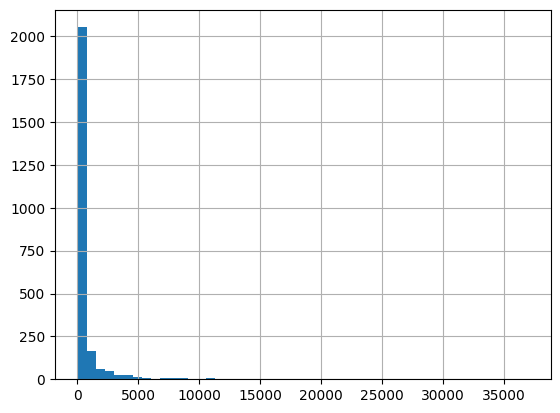

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
8218,40,#/100mL,NaN,NaN
8277,9,#/100mL,NaN,NaN
8285,20,#/100mL,NaN,NaN
8433,200,#/100mL,NaN,NaN
8597,NO DATA,#/100mL,"ResultMeasureValue: ""NO DATA"" result cannot be...",NaN
...,...,...,...,...
412403,2400.0,cfu/100mL,NaN,NaN
412405,230.0,cfu/100mL,NaN,NaN
412409,30.0,cfu/100mL,NaN,NaN
412413,NaN,cfu/100mL,ResultMeasureValue: missing (NaN) result,NaN


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: '%' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'count' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count     1278.000000
mean       626.068286
std       3462.583347
min          0.000000
25%         22.250000
50%         66.000000
75%        220.000000
max      72000.000000
dtype: float64
Unusable results: 22187
Usable results with inferred units: 0
Results outside threshold (0.0 to 21401.56837068052): 7


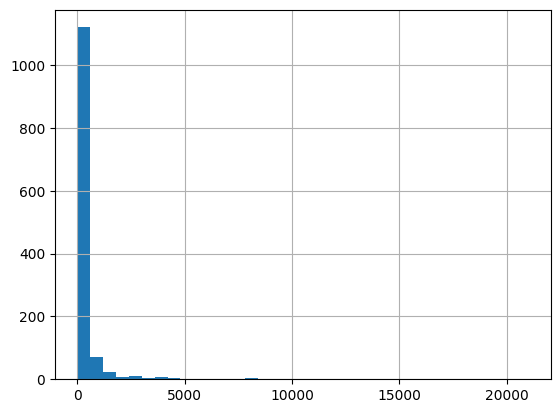

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
4,96,MPN/100mL,NaN,NaN
13,24200,MPN/100mL,NaN,NaN
16,110,MPN/100mL,NaN,NaN
19,52,MPN/100mL,NaN,NaN
24,52,MPN/100mL,NaN,NaN
...,...,...,...,...
416585,7.0,MPN/100 ml,NaN,7.0 Colony_Forming_Units / milliliter
416598,870.0,MPN/100 ml,NaN,870.0 Colony_Forming_Units / milliliter
416602,44.0,MPN/100 ml,NaN,44.0 Colony_Forming_Units / milliliter
416606,14.0,MPN/100 ml,NaN,14.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 30755 
Mean: 19.334148801040712 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[4003.4828342857154]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
22981,804,ppth,NaN,804.0 Practical_Salinity_Units
123274,71.49,ppth,NaN,71.49 Practical_Salinity_Units
124283,70.62,ppth,NaN,70.62 Practical_Salinity_Units
178350,77.6666666666667,ppt,NaN,77.6666666666667 Practical_Salinity_Units
382543,4980.0,mg/mL @25C,ResultTemperatureBasisText: updated from 25 de...,4003.4828342857154 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [78]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
11064,0,ppt,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
11515,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
11699,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
17297,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
18519,0,ppm,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
323504,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
323598,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
323652,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
323657,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore conductivity results:

In [79]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

18              349.0 microsiemens / centimeter
36              443.0 microsiemens / centimeter
43        67.11703531 microsiemens / centimeter
67              590.0 microsiemens / centimeter
109           418.375 microsiemens / centimeter
                          ...                  
310223          431.0 microsiemens / centimeter
310246          321.0 microsiemens / centimeter
310249          364.0 microsiemens / centimeter
310265          246.0 microsiemens / centimeter
310266          607.0 microsiemens / centimeter
Name: Conductivity, Length: 2599, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [80]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
105835,48.6,mS/cm,NaN,NaN,48600.0 microsiemens / centimeter
107360,48.15,mS/cm,NaN,NaN,48150.0 microsiemens / centimeter
62032,48,mS/cm,NaN,NaN,48000.0 microsiemens / centimeter
66824,46.9,mS/cm,NaN,NaN,46900.0 microsiemens / centimeter
106347,46.8,mS/cm,NaN,NaN,46800.0 microsiemens / centimeter
...,...,...,...,...,...
5042,0.03,uS/cm,NaN,NaN,0.03 microsiemens / centimeter
5287,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
2738,0.02,uS/cm,NaN,NaN,0.02 microsiemens / centimeter
6715,0,uS/cm,NaN,NaN,0.0 microsiemens / centimeter


In [81]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

105835    31.712 dimensionless
107360    31.384 dimensionless
62032     31.274 dimensionless
66824     30.474 dimensionless
106347    30.401 dimensionless
                  ...         
5042       0.012 dimensionless
5287       0.012 dimensionless
2738       0.012 dimensionless
6715       0.012 dimensionless
3156       0.012 dimensionless
Name: Salinity, Length: 2599, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [82]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
105835,2007-08-23,09:23:00,EST
107360,2007-08-09,08:14:00,EST
62032,2006-08-21,11:50:00,EST
66824,2006-08-07,10:00:00,EST
106347,2007-08-09,10:20:00,EST
...,...,...,...
416607,2024-01-08,12:00:00,EST
416608,2024-02-12,08:45:00,EST
416609,2024-02-12,08:45:00,EST
416610,2024-02-12,08:45:00,EST


In [83]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.12.4/x64/lib/python3.12/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 132776 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
105835,2007-08-23,2007-08-23 14:23:00+00:00
107360,2007-08-09,2007-08-09 13:14:00+00:00
62032,2006-08-21,2006-08-21 16:50:00+00:00
66824,2006-08-07,2006-08-07 15:00:00+00:00
106347,2007-08-09,2007-08-09 15:20:00+00:00
...,...,...
416607,2024-01-08,2024-01-08 17:00:00+00:00
416608,2024-02-12,2024-02-12 13:45:00+00:00
416609,2024-02-12,2024-02-12 13:45:00+00:00
416610,2024-02-12,2024-02-12 13:45:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [84]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

105835    0.15
107360    0.15
62032     0.15
66824     0.15
106347    0.15
          ... 
282332    0.15
282381    0.15
282388    0.15
282416    0.15
282452    0.15
Name: ResultDepthHeightMeasure/MeasureValue, Length: 2460, dtype: float64

#### Characteristic to Column (long to wide format)

In [85]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Other_Phosphorus,QA_Fecal_Coliform,QA_E_coli,QA_pH,QA_Carbon,QA_Sediment,QA_Nitrogen,QA_Turbidity,QA_DO,QA_Chlorophyll
105835,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070823092300:SO:1.5:WB,2007-08-23,09:23:00,-0500,WWMD_VA-BI1,STORET-1013198907,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107360,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070809081400:SO:1.7:WB,2007-08-09,08:14:00,-0500,WWMD_VA-BI1,STORET-1013198861,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62032,WWMD_VA,WQX Test Organization,WWMD_VA-SR6A:20060821115000:SO:0.8:WB,2006-08-21,11:50:00,-0500,WWMD_VA-SR6A,STORET-1013198845,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66824,WWMD_VA,WQX Test Organization,WWMD_VA-OB6:20060807100000:SO:1.7:WB,2006-08-07,10:00:00,-0500,WWMD_VA-OB6,STORET-1013198765,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106347,WWMD_VA,WQX Test Organization,WWMD_VA-LT1N:20070809102000:SO:0.75:WB,2007-08-09,10:20:00,-0500,WWMD_VA-LT1N,STORET-1013198891,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416607,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400495,2024-01-08,12:00:00,-0500,USGS-01098530,NWIS-126836828,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416608,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416609,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989056,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
416610,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02400639,2024-02-12,08:45:00,-0500,USGS-01097050,NWIS-126989063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [87]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

35873 fewer rows


In [88]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [89]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [90]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Secchi', 'QA_Salinity',
       'QA_Conductivity', 'QA_Temperature', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Fecal_Coliform',
       'QA_E_coli', 'QA_pH', 'QA_Carbon', 'QA_Sediment', 'QA_Nitrogen',
       'QA_Turbidity', 'QA_DO', 'QA_Chlorophyll'],
      dtype='object')

In [91]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Other_Phosphorus,QA_Fecal_Coliform,QA_E_coli,QA_pH,QA_Carbon,QA_Sediment,QA_Nitrogen,QA_Turbidity,QA_DO,QA_Chlorophyll
105835,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070823092300:SO:1.5:WB,WWMD_VA-BI1,STORET,NaN,NaN,NaN,NaN,31.712 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107360,WWMD_VA,WQX Test Organization,WWMD_VA-BI1:20070809081400:SO:1.7:WB,WWMD_VA-BI1,STORET,NaN,NaN,NaN,NaN,31.384 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62032,WWMD_VA,WQX Test Organization,WWMD_VA-SR6A:20060821115000:SO:0.8:WB,WWMD_VA-SR6A,STORET,NaN,NaN,NaN,NaN,31.274 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66824,WWMD_VA,WQX Test Organization,WWMD_VA-OB6:20060807100000:SO:1.7:WB,WWMD_VA-OB6,STORET,NaN,NaN,NaN,NaN,30.474 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106347,WWMD_VA,WQX Test Organization,WWMD_VA-LT1N:20070809102000:SO:0.75:WB,WWMD_VA-LT1N,STORET,NaN,NaN,NaN,NaN,30.401 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'DetectionQuantitationLimitTypeName',
 'DetectionQuantitationLimitMeasure/MeasureValue',
 'DetectionQuantitationLimitMeasure/MeasureUnitCode',
 'QA_Conductivity',
 'QA_TDP_Phosphorus',
 'QA_E_coli',
 'QA_Carbon',
 'QA_Sediment',
 'QA_DO']

<Axes: >

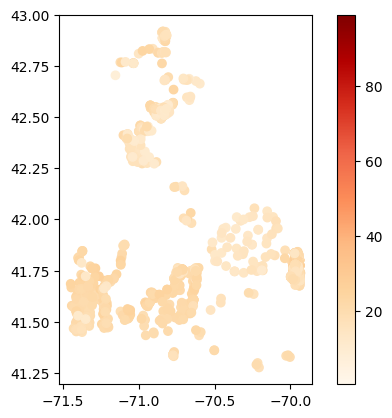

In [93]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)